## **Timeseries classification**

Given a timeseries dataset, we want to classify the timeseries into one of the classes. In order to reach the best result the test accuracy of some machine learning models is going to be compared. 

The task consists in classifying the timeseries in 4 different classes.

# **Data preparation**

## Get the session token

In [1]:
import http
import json
import ssl

conn = http.client.HTTPSConnection("tracker.elioslab.net", context=ssl._create_unverified_context())
## conn = http.client.HTTPSConnection("tracker.elioslab.net")
payload = json.dumps({
  "username": "LaFauci",
  "password": "LF_Password",
  "tenant": "sci-tenant"
})
headers = {
  'Content-Type': 'application/json'
}
conn.request("POST", "/v1/login", payload, headers)
res = conn.getresponse()
data = res.read()
data=json.loads(data.decode("utf-8"))
token=data['token']

## Definition of the functions

In [2]:
import json
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_timeseries_from_measurement(measureName):
  payload = ''
  headers = {
    'Content-Type': 'application/json',
    'Authorization': token
  }
  conn.request("GET", "/v1/measurements/"+measureName+"/timeserie?limit=2000&sort=%7B%20%22timestamp%22:%20%22asc%22%20%7D", payload, headers)
  res = conn.getresponse()
  response = res.read()
  response=json.loads(response)
  ##print(response)
  timeseries_signal=response['docs']
  return timeseries_signal

def extracting_signals(timeseries_signal):
    # Remove the first 10 and last 10 signals from timeseries_signal
    timeseries_signal = timeseries_signal[10:-10]

    values_all = []
    for k in timeseries_signal:
        values = [k["values"][0], k["values"][1], k["values"][2], k["values"][3], k["values"][4], k["values"][5]]
        values_all.append(values)

    signal_all = np.array(values_all)
    return signal_all
'''
def extracting_testing_signals(timeseries_signal,label,first_sample,last_sample):
    values_all = []
    for i in range(first_sample, last_sample):
        k = timeseries_signal[i]
        values = [k["values"][0], k["values"][1], k["values"][2], k["values"][3], k["values"][4], k["values"][5], label]
        # Append the extracted values to the values_all list
        values_all.append(values)
    # Convert the list of values into a numpy array
    signal_all = np.array(values_all)
    return signal_all
'''
def preprocess_file(directory, file_name):
    file_path = os.path.join(directory, file_name)
    column_names = ["xAcc", "yAcc", "zAcc", "xGyr", "yGyr", "zGyr", "label"]
    df = pd.read_table(file_path, delimiter=" ", names=column_names)  # Use names directly for header info
    return df

def scaling(dataset):
    X = dataset.iloc[:, :-1]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=dataset.columns[:-1])
    final_df = pd.concat([X_scaled_df, dataset.iloc[:, -1].reset_index(drop=True)], axis=1)
    return final_df

def windowing(dataset, window_length):
    datasets = [dataset[i:i+window_length] for i in range(0, len(dataset) - window_length, window_length)]
    return datasets

def sliding_windowing(dataset, window_length, step_size):
    datasets = [dataset[i:i+window_length] for i in range(0, len(dataset)-window_length+1, step_size)]
    return datasets

def get_labels(dataset):
    labels = []
    for window in dataset:
        label_counts = window['label'].value_counts()
        most_common_label = label_counts.idxmax()
        labels.append(most_common_label)
    return labels

def droplbl(dataset):
    dataset_nolbl = [block.drop("label", axis=1).values.ravel() for block in dataset]
    return dataset_nolbl

def get_features(window):
    

    # Compute the statistics for each feature
    stats_all = []
    for i in range(window.shape[1]):
        feature_values = window[:, i]
        stats = [np.mean(feature_values), np.std(feature_values), np.median(feature_values), 
                 np.min(feature_values), np.max(feature_values), 
                 np.percentile(feature_values, 25), np.percentile(feature_values, 50), 
                 np.percentile(feature_values, 75)]
        stats_all.extend(stats)
    stats_all=np.array(stats_all)
    return(stats_all)

## Creation of the folders to store the datasets

In [3]:
import os
import shutil

if not os.path.exists("./testing"):
    os.makedirs("./testing")
if not os.path.exists("./training"):
    os.makedirs("./training")
if not os.path.exists("./validation"):
    os.makedirs("./validation")
if not os.path.exists("./results"):
    os.makedirs("./results")
if not os.path.exists("./tuner_single_dense"):
    os.makedirs("./tuner_single_dense")

def delete_files_and_folders_in_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # remove file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # remove directory

delete_files_and_folders_in_directory("./testing")
delete_files_and_folders_in_directory("./validation")
delete_files_and_folders_in_directory("./training")
delete_files_and_folders_in_directory("./results")
delete_files_and_folders_in_directory("./tuner_single_dense")

## Separation of the timeseries for training,validation and testing

In [4]:
file_names_testing = ["test-All","test2-All","test3-All"]
file_names_special = ["test1-pista1","test-pistaBluLM","test7-pistaLuciaENsp"]
file_names_validation = [["test2-pistaPancaniLM","test3-pistaPancaniLM","test2-pistaBluLM"],["test7-pistaLuciaEN","test8-pistaLuciaEN","test9-pistaLuciaEN"],["test10-pistaLuciaENsp","test11-pistaLuciaENsp"],["test2-pistaAlpettaLMuo"]]
file_names_training = [["test1-pistaAlpettaLM","test2-pistaAlpettaLM","test3_pistaAlpettaLM","test-pistaAlpettaneraLM","test1-pistaPancaniLM","test-Slalom","test-Slalom2"],["test3-pista1","test4-pistababyEN","test5-pista1EN","test5-pistababyEN","test6-pista1EN","test6-pistaLuciaENsp","test-Spazzaneve","test-Spazzaneve2"],["test1-pista1ENsp","test3-pistaLuciaENsp","test4-pistaLuciaENsp","test5-pistaLuciaENsp","test8-pistaLuciaENsp","test9-pistaLuciaENsp","test-Spinta","test-Spinta2"],["test-pistaPancaniLMuo","test-pistaBluLMuo","test-Uovo","test-Uovo2"]]

## Extracting and saving the data

In [5]:
window_length=10
step_size=int(window_length/10)
training_dataset=[]
training_labels=[]
all_windows=[]
for index, files in enumerate(file_names_training): 
    for file in files:
        timeseries_signal = get_timeseries_from_measurement(file)
        signal_all = extracting_signals(timeseries_signal)
        windows=sliding_windowing(signal_all,window_length,step_size)
        for window in windows:
            features = get_features(np.array(window))
            # Add the features to the last sample of the window
            window_with_features = np.append(window[-1], features)
            all_windows.append(window_with_features)
        training_dataset.extend(all_windows)
        for _ in all_windows:
            training_labels.append(int(index))
        all_windows = []  # Reset for the next file

validation_dataset=[]
validation_labels=[]
val_windows=[]
for index, files in enumerate(file_names_validation): 
    for file in files:
        timeseries_signal = get_timeseries_from_measurement(file)
        signal_all = extracting_signals(timeseries_signal)
        windows=sliding_windowing(signal_all,window_length,step_size)
        for window in windows:
            features = get_features(np.array(window))
            # Add the features to the last sample of the window
            window_with_features = np.append(window[-1], features)
            val_windows.append(window_with_features)
        validation_dataset.extend(val_windows)
        for _ in val_windows:
            validation_labels.append(int(index))
        val_windows = []  # Reset for the next file

for measure in file_names_special:  
    all_windows = [] 
    timeseries_signal=get_timeseries_from_measurement(measure)
    signal_all=extracting_signals(timeseries_signal)
    signal_all=np.array([signal_all])
    if measure=="test1-pista1":
      signal_all1 = signal_all[0][:145]
      signal_all1=np.array([signal_all1])
      signal_all2 = signal_all[0][145:]
      signal_all2=np.array([signal_all2])

      windows=sliding_windowing(signal_all1,window_length, step_size)
      for window in windows:
        features = get_features(np.array(window))
        window_with_features = np.append(window[-1], features)
        all_windows.append(window_with_features)
      training_dataset.extend(all_windows)
      for _ in all_windows:
        training_labels.append(int(2))
      all_windows = []  # Reset for the next part

      windows=sliding_windowing(signal_all2,window_length, step_size)
      for window in windows:
        features = get_features(np.array(window))
        window_with_features = np.append(window[-1], features)
        all_windows.append(window_with_features)
      training_dataset.extend(all_windows)
      for _ in all_windows:
        training_labels.append(int(0))
      all_windows = []  # Reset for the next measure

    elif measure=="test-pistaBluLM":
      signal_all = signal_all[0][:206]
      signal_all=np.array([signal_all])
      windows=sliding_windowing(signal_all,window_length, step_size)
      for window in windows:
        features = get_features(np.array(window))
        window_with_features = np.append(window[-1], features)
        all_windows.append(window_with_features)
      training_dataset.extend(all_windows)
      for _ in all_windows:
        training_labels.append(int(1))
      all_windows = []  # Reset for the next measure

    elif measure=="test7-pistaLuciaENsp":
      signal_all = signal_all[0][:281]
      signal_all=np.array([signal_all])
      windows=sliding_windowing(signal_all,window_length, step_size)
      for window in windows:
        features = get_features(np.array(window))
        window_with_features = np.append(window[-1], features)
        all_windows.append(window_with_features)
      training_dataset.extend(all_windows)
      for _ in all_windows:
        training_labels.append(int(2))
      all_windows = []  # Reset for the next measure

dataset_testing=[]
labels_testing=[]
for file in file_names_testing:
    test_windows=[]
    timeseries_signal = get_timeseries_from_measurement(file)
    signal_all = extracting_signals(timeseries_signal)

    if file == "test-All":
        signal_all1 = signal_all[60:320] 
        signal_all2 = signal_all[320:400] 
        signal_all3 = signal_all[422:542] 
        signal_all4 = signal_all[542:] 
        
        windows=sliding_windowing(signal_all1,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(1))
        test_windows = []
        
        windows=sliding_windowing(signal_all2,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(2))
        test_windows = []

        windows=sliding_windowing(signal_all3,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(0))
        test_windows = []
        
        windows=sliding_windowing(signal_all4,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(3))
        test_windows = []
        
    elif file=="test2-All":
        signal_all1 = signal_all[40:188]
        signal_all2 = signal_all[188:282]
        signal_all3 = signal_all[332:483]
        signal_all4 = signal_all[495:675]
    
        
        #windows=sliding_windowing(signal_all1,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(0))
        test_windows = []
        
        windows=sliding_windowing(signal_all2,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(3))
        test_windows = []

        windows=sliding_windowing(signal_all3,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(1))
        test_windows = []
        
        windows=sliding_windowing(signal_all4,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(2))
        test_windows = []
        
    elif file=="test3-All":
        signal_all1 = signal_all[:137]
        signal_all2 = signal_all[137:258]
        signal_all3 = signal_all[258:378]
        signal_all4 = signal_all[383:]
    
    
        windows=sliding_windowing(signal_all1,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(2))
        test_windows = []
        
        windows=sliding_windowing(signal_all2,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(3))
        test_windows = []

        windows=sliding_windowing(signal_all3,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(0))
        test_windows = []
        
        windows=sliding_windowing(signal_all4,window_length,step_size)
        for window in windows:
            window_with_features = np.append(window[-1], get_features(np.array(window)))
            test_windows.append(window_with_features)
        dataset_testing.extend(test_windows)
        for _ in test_windows:
            labels_testing.append(int(1))
        test_windows = []

In [6]:
print(len(training_dataset))
print(len(training_labels))
print(len(validation_dataset))
print(len(validation_labels))
print(len(dataset_testing))
print(len(labels_testing))

5408
5408
2348
2348
776
776


## Preprocess the files

### Scaling the dataset

In [7]:
training_dataset = np.array(training_dataset)
validation_dataset = np.array(validation_dataset)
dataset_testing = np.array(dataset_testing)
len_training = training_dataset.shape[0]
print(training_dataset.shape[0])
len_validation = validation_dataset.shape[0]
print(validation_dataset.shape[0])
len_testing = dataset_testing.shape[0]
print(dataset_testing.shape[0])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform both training and validation data
training_dataset = scaler.fit_transform(training_dataset.reshape(-1, len_training)).reshape(training_dataset.shape)
validation_dataset = scaler.fit_transform(validation_dataset.reshape(-1, len_validation)).reshape(validation_dataset.shape)
dataset_testing = scaler.fit_transform(dataset_testing.reshape(-1, len_testing)).reshape(dataset_testing.shape)


# Convert dataset to a NumPy array
training_dataset = np.array(training_dataset)
training_dataset.shape
training_labels=np.array(training_labels)
validation_dataset = np.array(validation_dataset)
validation_dataset.shape
validation_labels=np.array(validation_labels)
dataset_testing = np.array(dataset_testing)
dataset_testing.shape
labels_testing=np.array(labels_testing)

5408
2348
776


In [8]:
X_train = np.array(training_dataset)
y_train = np.array(training_labels)
X_val = np.array(validation_dataset)
y_val = np.array(validation_labels)
X_test = np.array(dataset_testing)
y_test = np.array(labels_testing)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5408, 54)
(2348, 54)
(776, 54)


In [9]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

5408
2348
776


Modification in order to mix the training and the validation values before splitting then in order to take both dataset from the same data and don't have missmatches.

## Print the dataset statistics

In [10]:
print("Training dataset:")
print("Samples number 0: ", np.count_nonzero(y_train == 0))
print("Samples number 1: ", np.count_nonzero(y_train == 1))
print("Samples number 2: ", np.count_nonzero(y_train == 2))
print("Samples number 3: ", np.count_nonzero(y_train == 3))

print("Validation dataset:")
print("Samples number 0: ", np.count_nonzero(y_val == 0))
print("Samples number 1: ", np.count_nonzero(y_val == 1))
print("Samples number 2: ", np.count_nonzero(y_val == 2))
print("Samples number 3: ", np.count_nonzero(y_val == 3))

print("Testing dataset:")
print("Samples number 0: ", np.count_nonzero(y_test == 0))
print("Samples number 1: ", np.count_nonzero(y_test == 1))
print("Samples number 2: ", np.count_nonzero(y_test == 2))
print("Samples number 3: ", np.count_nonzero(y_test == 3))

Training dataset:
Samples number 0:  1755
Samples number 1:  1811
Samples number 2:  1206
Samples number 3:  636
Validation dataset:
Samples number 0:  1036
Samples number 1:  787
Samples number 2:  341
Samples number 3:  184
Testing dataset:
Samples number 0:  170
Samples number 1:  278
Samples number 2:  171
Samples number 3:  157


In [11]:
linear_classifier_accuracy=[]
MLP_classifier_accuracy=[]
CNN_classifier_accuracy=[]
DCNN_classifier_accuracy=[]
NN_model_sizes=[]

# **NN models**

In this section we implement all general functions that can be used by all NN models

## Epochs and batch size configuration

In [12]:
epochs=75
batch_size=16

## Import needed libraries

In [13]:
import tracemalloc
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import joblib
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


## Generalized functions

In [14]:
def plot_model_performance(history,number_of_epochs):
  plt.figure()
  plt.plot(history.history['loss'], 'g', label='Training Loss')
  plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
def NN_hyperparameter_fit(hyperparameter,Type_model):
  if (Type_model=="CNN"):
    model=build_model(hyperparameter)
  if (Type_model=="DCNN"):
    model=build_model_DCNN(hyperparameter)
  early_stopping = EarlyStopping(monitor='val_loss', patience=100)
  model.summary()
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1500, callbacks=[early_stopping])
  plot_model_performance(history,epochs)
  return model,history

In [16]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

def evaluate_NN_models(model_list):
  loss, accuracy , y_pred ,precision, recall ,f1_score ,support ,confusion_matrix_list = [], [], [], [], [], [], [], []
  for model in model_list:
    loss_value,accuracy_value=model.evaluate(X_test, y_test)
    loss.append(loss_value)
    accuracy.append(accuracy_value)
    y_pred_value=np.argmax(model.predict(X_test), axis=-1)
    y_pred.append(y_pred_value)
    precision_value, recall_value, f1_score_value, support_value = precision_recall_fscore_support(y_test , y_pred_value, average= 'macro' )
    precision.append(precision_value)
    recall.append(recall_value)
    f1_score.append(f1_score_value)
    support.append(support_value)
    confusion_matrix_value=confusion_matrix(y_test, y_pred_value)
    confusion_matrix_list.append(confusion_matrix_value)
  return [accuracy ,precision, recall ,f1_score],confusion_matrix_list,y_pred

In [17]:
from tabulate import tabulate
def print_table(data,headers):
  table_data = list(zip(*data))
  table = tabulate(table_data, headers=headers, tablefmt='grid')
  print(table)

In [18]:
def calculate_ML_size(model,file_name):
  # Create the folder if it doesn't exist
  if not os.path.exists("results"):
    os.makedirs("results")

  # Construct the complete filename with extension within the folder
  model_filename = os.path.join("results", file_name + ".joblib")

  # Save the model using joblib
  joblib.dump(model, model_filename)

  # Get the size of the saved model file
  file_size = os.path.getsize(model_filename)

  return file_size

In [19]:
def format_memory(memory_bytes):
    if memory_bytes < 1024:
        return f"{memory_bytes} B"
    elif memory_bytes < 1024 * 1024:
        return f"{memory_bytes / 1024:.2f} KB"
    elif memory_bytes < 1024 * 1024 * 1024:
        return f"{memory_bytes / (1024 * 1024):.2f} MB"
    else:
        return f"{memory_bytes / (1024 * 1024 * 1024):.2f} GB"

In [20]:
def plot_model_performace_accuracy(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
  ax1.plot(history[0].history['accuracy'], 'g', label='Training Accuracy')
  ax1.plot(history[0].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax1.set_title('training and validation')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.set_ylim(0.7, 1)
  ax1.grid(True)
  ax1.legend()
  ax2.plot(history[1].history['accuracy'], 'g', label='Training Accuracy')
  ax2.plot(history[1].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax2.set_title('training and validation')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.set_ylim(0.7, 1)
  ax2.grid(True)
  ax2.legend()
  ax3.plot(history[2].history['accuracy'], 'g', label='Training Accuracy')
  ax3.plot(history[2].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax3.set_title('training and validation')
  ax3.set_xlabel('epoch')
  ax3.set_ylabel('accuracy')
  ax3.set_ylim(0.7, 1)
  plt.grid(True)
  plt.legend()
  plt.show()

In [21]:
def plot_confusion_matrix(ax, conf_matrix, title, cmap, labels):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def draw_confusion_matrix(matrix,name):
  colormap=["Blues","Greens","Oranges"]
  fig, axes = plt.subplots(1, len(matrix), figsize=(15, 5))
  
  # Create a list of string labels
  labels = ['slalom', 'spazzaneve', 'spinta', 'uovo']

  for i in range(len(matrix)):
    plot_confusion_matrix(axes[i], matrix[i], "Confusion Matrix  "+name+ str(i+1), colormap[i % len(colormap)], labels)
  plt.tight_layout()
  plt.show()

In [22]:
def ML_hyperparameters_study(classifier, param_grid, X_train_ML, X_test_ML, y_train_full_ML, y_test_full_ML,random=False):
    classifier.random_state = 42
    grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=1)
    grid_search.fit(X_train_ML, y_train_full_ML)
    results = grid_search.cv_results_
    mean_training_score_all = []
    params_all = []
    testing_accuracy = []
    models_size = []
    execution_time_list = []
    total_allocated_memory=[]
    average_allocated_memory=[]
    precision_list, recall_list, f1_score_list=[],[],[]

    def fit_and_measure_memory(model, X_train_ML, y_train_full_ML):
      tracemalloc.start()
      start_time = time.time()
      model.fit(X_train_ML, y_train_full_ML)
      snapshot = tracemalloc.take_snapshot()
      tracemalloc.stop()
      end_time = time.time()
      execution_time_list.append(end_time - start_time)
      return snapshot

    for mean_score, params in zip(results['mean_test_score'], results['params']):
        mean_training_score_all.append(mean_score)
        params_all.append(params)
        hyper_model = classifier
        if random:
            hyper_model.random_state = 42
        hyper_model.set_params(**params)
        snap = fit_and_measure_memory(hyper_model, X_train_ML, y_train_full_ML)
        # Calculate the total allocated memory from the snapshot
        total_memory=sum(stat.size for stat in snap.statistics('lineno'))
        total_allocated_memory.append(format_memory(total_memory))
        # Calculate the average allocated memory
        num_snapshots = len(snap.statistics('lineno'))
        average_allocated_memory.append(format_memory(total_memory / num_snapshots))
        y_pred = hyper_model.predict(X_test_ML)
        testing_accuracy.append(accuracy_score(y_test_full_ML, y_pred))
        precision_value, recall_value, f1_score_value, support_value = precision_recall_fscore_support(y_test_full_ML , y_pred, average= 'weighted' )
        precision_list.append(precision_value)
        recall_list.append(recall_value)
        f1_score_list.append(f1_score_value)
        models_size.append(format_memory(calculate_ML_size(hyper_model, "model(" + str(mean_score) + ")")))

    best_params = grid_search.best_params_
    return [params_all,testing_accuracy,precision_list,recall_list,f1_score_list, models_size, execution_time_list,total_allocated_memory,average_allocated_memory], best_params ,mean_training_score_all

In [23]:
X_train_ML= np.array([np.array(x_train).reshape(-1) for x_train in X_train])
X_val_ML=np.array([np.array(x_val).reshape(-1) for x_val in X_val])
X_test_ML=np.array([np.array(x_test).reshape(-1) for x_test in X_test])

print('Shape:', X_train_ML.shape)
print('Type:', X_train_ML.dtype)
print('Shape:', X_val_ML.shape)
print('Type:', X_val_ML.dtype)
print('Shape:', X_test_ML.shape)
print('Type:', X_test_ML.dtype)



Shape: (5408, 54)
Type: float64
Shape: (2348, 54)
Type: float64
Shape: (776, 54)
Type: float64


In [24]:
# Print the shape of the input data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Print the first few entries of the input data
if isinstance(X_train, pd.DataFrame):
    print(X_train.head())

Shape of X_train: (5408, 54)
Shape of y_train: (5408,)


# **Linear SVM Classifier**

In [25]:
import numpy as np
X_Train_Full = np.concatenate((X_train_ML, X_val_ML), axis=0)
y_Train_Full = np.concatenate((y_train, y_val), axis=0)
print('Shape of X_Train_Full:', X_Train_Full.shape)
print('Type of X_Train_Full:', X_Train_Full.dtype)
print('Shape of y_Train_Full:', y_Train_Full.shape)
print('Type of y_Train_Full:', y_Train_Full.dtype)

Shape of X_Train_Full: (7756, 54)
Type of X_Train_Full: float64
Shape of y_Train_Full: (7756,)
Type of y_Train_Full: int32


In [26]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

param_grid = {
    'alpha': [0.015329113348766826, 0.006022808863980392, 0.4171948766858128, 0.4345045705035633, 0.49356259465914804,]
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='micro'),
    'recall': make_scorer(recall_score, average='micro'),
    'f1_score': make_scorer(f1_score, average='micro')
}

models_info_linear,best_params_linear,mean_training_score_all_linear = ML_hyperparameters_study(SGDClassifier(),param_grid,X_Train_Full, X_test_ML, y_Train_Full, y_test, random=True)
headers_linear=list(param_grid.keys())

headers_linear=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(1, len(param_grid['alpha'])+1):
  models_name.append("Linear model " + str(i))
data_linear=[models_name]
data_linear.extend(models_info_linear)
print_table(data_linear,headers_linear)
linear_classifier_accuracy=models_info_linear[1]


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

+----------------+---------------------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| models         | hyperparameters                 |    accuracy  |   precision |   recall |   f1_score | model size   |   Runtime | total allocated memory   | average allocated memory   |
+================+=================================+==============+=============+==========+============+==============+===========+==========================+============================+
| Linear model 1 | {'alpha': 0.015329113348766826} |     0.550258 |    0.519447 | 0.550258 |   0.495569 | 2.81 KB      | 0.122687  | 10.23 KB                 | 268.53846153846155 B       |
+----------------+---------------------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| Linear model 2 | {'alpha': 0.006022808863980392} |   

# **Random Forest Classifier**

In [27]:
param_grid = {
    'n_estimators': [50],
    'criterion': ['gini'],
    'max_depth': [None, 5, 10, 20, 30]
}

models_info_RF,best_params_RF,mean_training_score_all_RF  = ML_hyperparameters_study(RandomForestClassifier(),param_grid,X_train_ML, X_test_ML, y_train, y_test,random=True)

headers_RF=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(len(models_info_RF[0])):
  models_name.append("RF model " + str(i))
data_RF=[models_name]
data_RF.extend(models_info_RF)
print_table(data_RF,headers_RF)
print("best hyperparameter : ", best_params_RF)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
+------------+--------------------------------------------------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| models     | hyperparameters                                              |    accuracy  |   precision |   recall |   f1_score | model size   |   Runtime | total allocated memory   | average allocated memory   |
+============+==============================================================+==============+=============+==========+============+==============+===========+==========================+============================+
| RF model 0 | {'criterion': 'gini', 'max_depth': None, 'n_estimators': 50} |     0.451031 |    0.429672 | 0.451031 |   0.418997 | 5.94 MB      |   6.04609 | 41.00 KB                 | 763.3090909090909 B        |
+------------+--------------------------------------------------------------+-------

# **KNN Classifier**

In [28]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

models_info_KNN,best_params_KNN,mean_training_score_all_KNN = ML_hyperparameters_study(KNeighborsClassifier(),param_grid,X_train_ML, X_test_ML, y_train, y_test,random=False)


#### visulaize all hyperparameters with acuuracy and model size in one table

headers_KNN=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(len(models_info_KNN[0])):
    models_name.append("KNN model " + str(i))
data_KNN=[models_name]
data_KNN.extend(models_info_KNN)
print_table(data_KNN,headers_KNN)
print("best hyperparameter : ", best_params_KNN)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
+-------------+-------------------------------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| models      | hyperparameters                           |    accuracy  |   precision |   recall |   f1_score | model size   |   Runtime | total allocated memory   | average allocated memory   |
+=============+===========================================+==============+=============+==========+============+==============+===========+==========================+============================+
| KNN model 0 | {'n_neighbors': 3, 'weights': 'uniform'}  |     0.469072 |    0.463457 | 0.469072 |   0.455343 | 2.27 MB      |         0 | 44.10 KB                 | 3.39 KB                    |
+-------------+-------------------------------------------+--------------+-------------+----------+------------+--------------+-----------+-----------------

# **Fully connected NN (MLP)**

In [29]:
# Print the shape of the data
print("Shape of X_train:", X_train.shape)

# Number of samples
samples = X_train.shape[0]
print("Number of samples:", samples)

# Number of timesteps
timesteps = X_train.shape[1]
print("Number of timesteps:", timesteps)

features = 1

Shape of X_train: (5408, 54)
Number of samples: 5408
Number of timesteps: 54


In [30]:
from tensorflow.keras import regularizers

def build_model_fc(number_of_hidden_layers, number_of_units, num_classes, learning_rate=0.0001):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))
    for i in range(number_of_hidden_layers):
        model.add(tf.keras.layers.LSTM(number_of_units[i], return_sequences=True, kernel_regularizer=regularizers.l1(0.01)))
        model.add(tf.keras.layers.Dropout(rate = 0.3))
    model.add(tf.keras.layers.LSTM(number_of_units[-1], kernel_regularizer=regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    return model, history

## Creating grid of hyperparameters values

In [31]:
import random

min_num_hidden_layers = 1  # Minimum number of LSTM layers
max_num_hidden_layers = 5  # Maximum number of LSTM layers
min_length = 32  # Minimum number of units in each LSTM layer
max_length = 256  # Maximum number of units in each LSTM layer
num_hidden_layers=[]
hidden_layer_lengths = []
num_layers = random.randint(min_num_hidden_layers, max_num_hidden_layers)
number_of_models=6
for _ in range(number_of_models):
    num_layers = random.randint(min_num_hidden_layers, max_num_hidden_layers)
    num_hidden_layers.append(num_layers)
    # Generate a list of random numbers between min_length and max_length
    layer_lengths = [random.randint(min_length, max_length) for _ in range(num_layers)]
    hidden_layer_lengths.append(layer_lengths)

for i in range(len(num_hidden_layers)):
  print(f"LSTM layer :{num_hidden_layers[i]} , units: {hidden_layer_lengths[i]}")

LSTM layer :4 , units: [84, 153, 108, 88]
LSTM layer :1 , units: [147]
LSTM layer :4 , units: [111, 129, 183, 246]
LSTM layer :5 , units: [137, 192, 250, 69, 77]
LSTM layer :2 , units: [106, 36]
LSTM layer :2 , units: [76, 83]


## **build** and **train** 6 different MLP models each with different hyperparameters values

In [32]:
'''
models_list_MLP=[]
results_MLP=[]
for i in range(len(num_hidden_layers)):
  model,results=build_model_fc(num_hidden_layers[i],hidden_layer_lengths[i],4)
  models_list_MLP.append(model)
  results_MLP.append(results)
  plot_model_performance(results,epochs)
  '''

'\nmodels_list_MLP=[]\nresults_MLP=[]\nfor i in range(len(num_hidden_layers)):\n  model,results=build_model_fc(num_hidden_layers[i],hidden_layer_lengths[i],4)\n  models_list_MLP.append(model)\n  results_MLP.append(results)\n  plot_model_performance(results,epochs)\n  '

## Choose the best three MLP models

In [33]:
###print(len(models_list_MLP))  # Should be > 0
##print(models_list_MLP[0])  # Should print a model summary

In [34]:
'''
result_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(models_list_MLP)
def find_top_three_indexes(lst):
    arr = np.array(lst)
    top_indexes = arr.argsort()[-3:][::-1]
    return top_indexes

# Example usage:
top_three_indexes = find_top_three_indexes(result_all_models_FC[0])
print("Indexes of the top three values:", top_three_indexes)
'''

'\nresult_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(models_list_MLP)\ndef find_top_three_indexes(lst):\n    arr = np.array(lst)\n    top_indexes = arr.argsort()[-3:][::-1]\n    return top_indexes\n\n# Example usage:\ntop_three_indexes = find_top_three_indexes(result_all_models_FC[0])\nprint("Indexes of the top three values:", top_three_indexes)\n'

## Train 3 models with the entire training set:

In [35]:
'''
MLP_best_models=[models_list_MLP[top_three_indexes[0]],models_list_MLP[top_three_indexes[1]],models_list_MLP[top_three_indexes[2]]]
model1=MLP_best_models[0]
model2=MLP_best_models[1]
model3=MLP_best_models[2]
results_total_train1 = model1.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)
results_total_train2 = model2.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)
results_total_train3 = model3.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)
'''

'\nMLP_best_models=[models_list_MLP[top_three_indexes[0]],models_list_MLP[top_three_indexes[1]],models_list_MLP[top_three_indexes[2]]]\nmodel1=MLP_best_models[0]\nmodel2=MLP_best_models[1]\nmodel3=MLP_best_models[2]\nresults_total_train1 = model1.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)\nresults_total_train2 = model2.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)\nresults_total_train3 = model3.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)\n'

In [36]:
'''
models_list_FC = []
models_list_FC.append(model1)
models_list_FC.append(model2)
models_list_FC.append(model3)
'''

'\nmodels_list_FC = []\nmodels_list_FC.append(model1)\nmodels_list_FC.append(model2)\nmodels_list_FC.append(model3)\n'

In [37]:
###plot_model_performace_accuracy([results_MLP[top_three_indexes[0]],results_MLP[top_three_indexes[0]],results_MLP[top_three_indexes[0]]])

## Evaluate the best three MLP models

In [38]:
'''
result_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(MLP_best_models)

## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']

hyperparameters_values=[]
models=[]
for i in range(len(top_three_indexes)):
  hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")
  models.append(f"MLP Model{i}")
data_normal_FC=[models]
data_normal_FC.append(hyperparameters_values)
data_normal_FC.extend(result_all_models_FC)
print_table(data_normal_FC,headers)
MLP_classifier_accuracy=result_all_models_FC[0]
'''

'\nresult_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(MLP_best_models)\n\n## create a table with all models results\nheaders=[\'models\',\'hyperparameter\',\'accuracy\',\'precision\',\'recall\',\'f1_score\']\n\nhyperparameters_values=[]\nmodels=[]\nfor i in range(len(top_three_indexes)):\n  hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")\n  models.append(f"MLP Model{i}")\ndata_normal_FC=[models]\ndata_normal_FC.append(hyperparameters_values)\ndata_normal_FC.extend(result_all_models_FC)\nprint_table(data_normal_FC,headers)\nMLP_classifier_accuracy=result_all_models_FC[0]\n'

In [39]:
###draw_confusion_matrix(confusion_matrix_FC,"MLP model")

# **CNN**

In [40]:
timesteps = X_train.shape[1]
features = 1
num_classes = 4

In [41]:
def build_model(hp, kernel_size=3):
    random_values = [random.uniform(0.045, 0.05) for _ in range(10)]

    random_values.sort()

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=random_values)
    
    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam'])

    # Tune the number of filters in the Conv1D layer
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=8)
    # Tune the dropout values
    dropout_rate = hp.Choice('dropout', values=[0.5, 0.7])
    # Tune weights initialization
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))  # Adjusted for 1D input
    model.add(tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernel_size, activation='relu', kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.01)))

    model.add(tf.keras.layers.Dropout(rate = dropout_rate))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Activation('softmax'))

    
    # Compile the model with the hyperparameters
    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    return model

## Observe the most performing models and identify their hyperparameters:

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner
from kerastuner.tuners import BayesianOptimization
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Bayesian Optimization with Early Stopping
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_single_dense',
    project_name='training_tuner_single_dense4'
)

tuner.search(X_train, y_train, epochs=epochs,
             batch_size=batch_size, validation_data=(X_val, y_val),
             callbacks=[early_stopping])

Trial 20 Complete [00h 00m 34s]
val_accuracy: 0.7172061204910278

Best val_accuracy So Far: 0.7440374493598938
Total elapsed time: 00h 12m 04s


In [43]:
num_trials = 40
best_trials = tuner.oracle.get_best_trials(num_trials=num_trials)
for idx, trial in enumerate(best_trials):
    print(f"Set {idx + 1}: {trial.hyperparameters.values}")
    print(f"Validation Accuracy: {trial.score}")

Set 1: {'learning_rate': 0.04638580297424627, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Validation Accuracy: 0.7440374493598938
Set 2: {'learning_rate': 0.04642614608559085, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Validation Accuracy: 0.7308347821235657
Set 3: {'learning_rate': 0.048855280439566724, 'optimizer': 'adam', 'filters': 16, 'dropout': 0.5, 'kernel_initializer': 'lecun_normal'}
Validation Accuracy: 0.7261499166488647
Set 4: {'learning_rate': 0.04681948043793177, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Validation Accuracy: 0.7257240414619446
Set 5: {'learning_rate': 0.04681948043793177, 'optimizer': 'adam', 'filters': 40, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Validation Accuracy: 0.7252981066703796
Set 6: {'learning_rate': 0.04638580297424627, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initi

In [44]:
num_trials = 20
best_hps2 = tuner.get_best_hyperparameters(num_trials=num_trials)
for idx, hyperparameters in enumerate(best_hps2):
    print(f"Set {idx + 1}: {hyperparameters.values}")

Set 1: {'learning_rate': 0.04638580297424627, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 2: {'learning_rate': 0.04642614608559085, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 3: {'learning_rate': 0.048855280439566724, 'optimizer': 'adam', 'filters': 16, 'dropout': 0.5, 'kernel_initializer': 'lecun_normal'}
Set 4: {'learning_rate': 0.04681948043793177, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 5: {'learning_rate': 0.04681948043793177, 'optimizer': 'adam', 'filters': 40, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 6: {'learning_rate': 0.04638580297424627, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 7: {'learning_rate': 0.04681948043793177, 'optimizer': 'adam', 'filters': 64, 'dropout': 0.5, 'kernel_initializer': 'lecun_normal'}
Set 8: {'learning_rate': 0.0452226536

In [45]:
best_hyperparameter_CNN=[best_hps2[0],best_hps2[1],best_hps2[2]]

## Train 3 CNN models and plot performance

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 52, 56)            224       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 26, 56)           0         
 1D)                                                             
                                                                 
 dense_4 (Dense)             (None, 26, 32)            1824      
                                                                 
 dense_5 (Dense)             (None, 26, 4)             132       
                                                                 
 dropout_1 (Dropout)         (None, 26, 4)             0         
                                                                 
 flatten_1 (Flatten)         (None, 104)               0         
                                                      

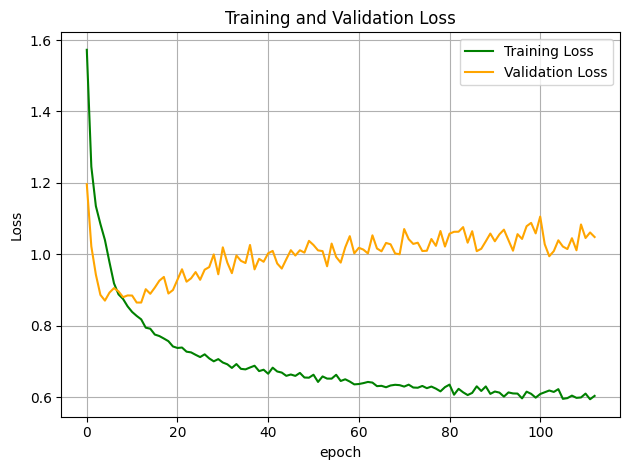

In [46]:
model4,results4=NN_hyperparameter_fit(best_hyperparameter_CNN[0],"CNN")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 52, 48)            192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 26, 48)           0         
 1D)                                                             
                                                                 
 dense_8 (Dense)             (None, 26, 32)            1568      
                                                                 
 dense_9 (Dense)             (None, 26, 4)             132       
                                                                 
 dropout_2 (Dropout)         (None, 26, 4)             0         
                                                                 
 flatten_2 (Flatten)         (None, 104)               0         
                                                      

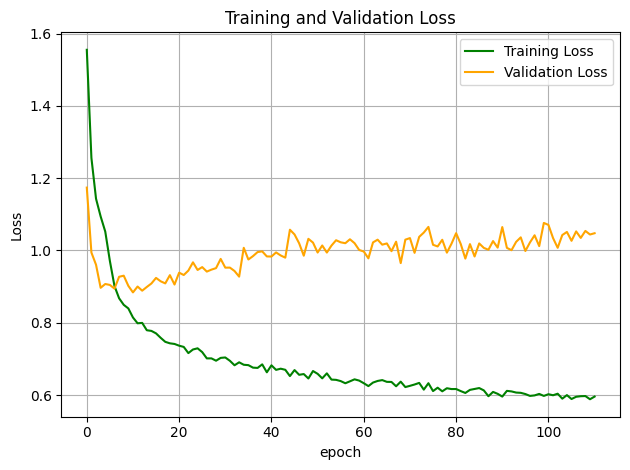

In [47]:
model5,results5=NN_hyperparameter_fit(best_hyperparameter_CNN[1],"CNN")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 52, 16)            64        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 26, 16)           0         
 1D)                                                             
                                                                 
 dense_12 (Dense)            (None, 26, 32)            544       
                                                                 
 dense_13 (Dense)            (None, 26, 4)             132       
                                                                 
 dropout_3 (Dropout)         (None, 26, 4)             0         
                                                                 
 flatten_3 (Flatten)         (None, 104)               0         
                                                      

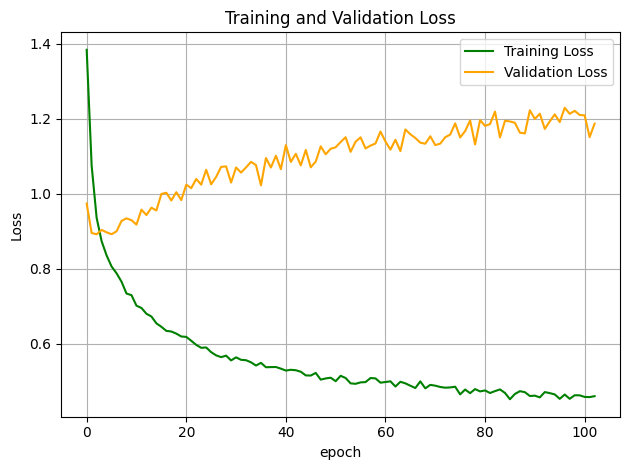

In [48]:
model6,results6=NN_hyperparameter_fit(best_hyperparameter_CNN[2],"CNN")

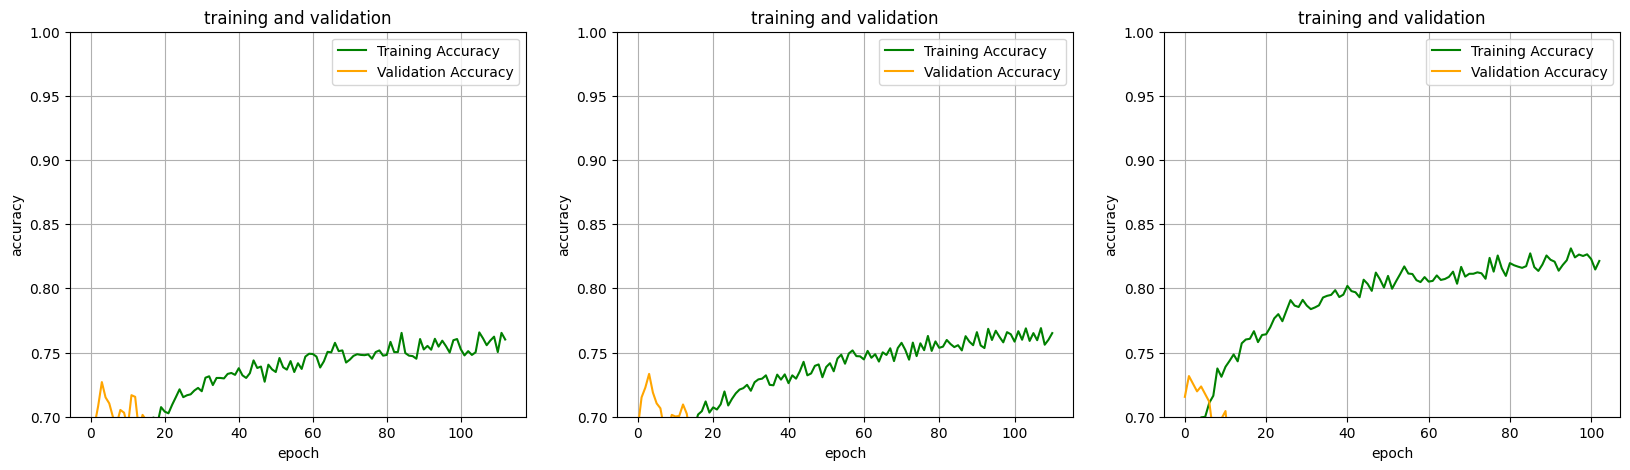

In [49]:
plot_model_performace_accuracy([results4,results5,results6])

## Let's train the three models with the entire training set:

In order to do this we need to train the models with the training and validation dataset.

In [50]:
import numpy as np

dataset=np.concatenate((X_train,X_val))
labels=np.concatenate((y_train,y_val))

In [51]:
# Fit the models
results_total_train4 = model4.fit(dataset, labels, epochs=75, batch_size=batch_size)
results_total_train5 = model5.fit(dataset, labels, epochs=75, batch_size=batch_size)
results_total_train6 = model6.fit(dataset, labels, epochs=75, batch_size=batch_size)

Epoch 1/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7488 - accuracy: 0.7201
Epoch 2/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7279 - accuracy: 0.7220
Epoch 3/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7257 - accuracy: 0.7251
Epoch 4/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7267 - accuracy: 0.7175
Epoch 5/75
485/485 [==============================] - 1s 3ms/step - loss: 0.7174 - accuracy: 0.7277
Epoch 6/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7146 - accuracy: 0.7218
Epoch 7/75
485/485 [==============================] - 2s 4ms/step - loss: 0.7083 - accuracy: 0.7245
Epoch 8/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7038 - accuracy: 0.7304
Epoch 9/75
485/485 [==============================] - 1s 3ms/step - loss: 0.7147 - accuracy: 0.7268
Epoch 10/75
485/485 [==============================] - 2s 3ms/step - loss: 0.7094 - accuracy: 0.7295

In [52]:
models_list_CNN = []
models_list_CNN.append(model4)
models_list_CNN.append(model5)
models_list_CNN.append(model6)

In [53]:
for model in models_list_CNN:
    predictions = model.predict(dataset_testing)
    predicted_labels = np.argmax(predictions, axis=1)
    print("Predicted labels:   ", predicted_labels)
    print("Ground-truth labels:",labels_testing)

25/25 [==============================] - 0s 2ms/step
Predicted labels:    [2 2 2 2 2 2 2 2 1 1 0 2 2 2 2 2 2 2 2 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 3 0 0 2 2 0 0 0 0 0 3 3 0 2 3 3 3 0 3 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 3 3 3 3 3 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 0 0 0 0 2 2 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 3 2 3 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 0 0 0 0 0 2 2 0 0 0 3 0

## Evaluate the CNN models on test set:
We evaluate all the models and print out a table with all the paramaters (model, hyperparameters, accuracy, precision, recall, f1_score)

In [54]:
result_all_models_CNN,confusion_matrix_CNN,predicitions=evaluate_NN_models(models_list_CNN)
## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']
data_normal_CNN=[['CNN model 1',' CNN model 2', 'CNN model 3']]
hyperparameters_values=[]
for idx, hyperparameters in enumerate(best_hyperparameter_CNN):
  hyperparameters_values.append(hyperparameters.values)
data_normal_CNN.append(hyperparameters_values)
data_normal_CNN.extend(result_all_models_CNN)
print_table(data_normal_CNN,headers)
CNN_classifier_accuracy=result_all_models_CNN[0]

25/25 [==============================] - 0s 2ms/step
+-------------+------------------------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+
| models      | hyperparameter                                                                                                                     |   accuracy |   precision |   recall |   f1_score |
+=============+====================================================================================================================================+============+=============+==========+============+
| CNN model 1 | {'learning_rate': 0.04638580297424627, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'} |   0.454897 |    0.418269 | 0.406047 |   0.374851 |
+-------------+------------------------------------------------------------------------------------------------------------------------------------

Now we draw a confusion matrix in order to make visible our results.

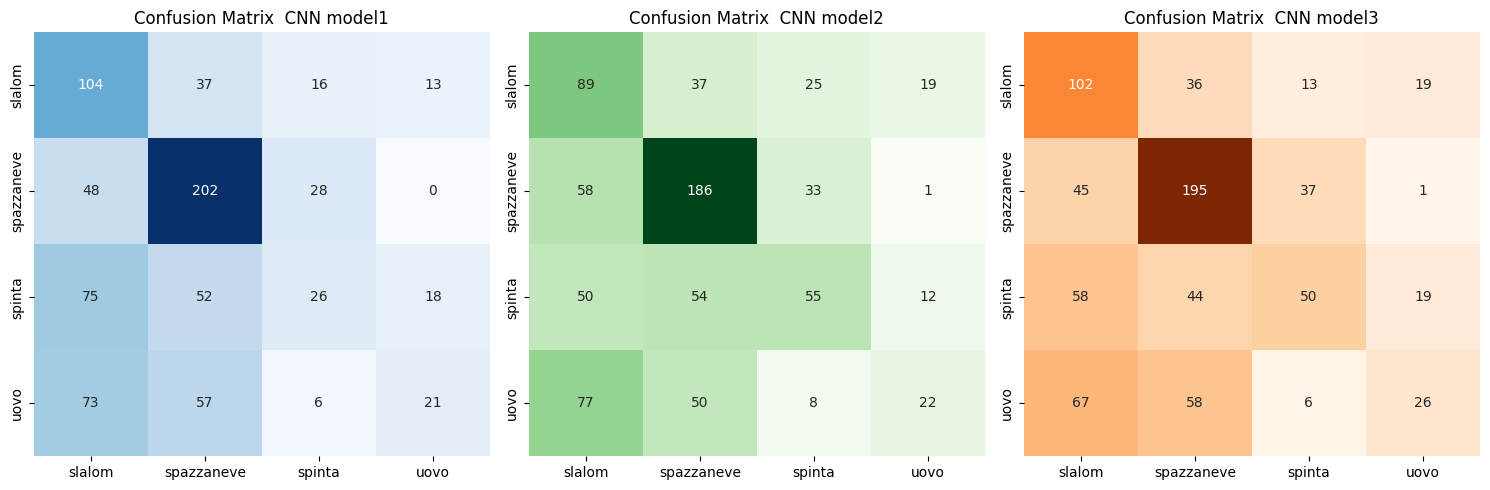

In [55]:
draw_confusion_matrix(confusion_matrix_CNN,"CNN model")

# **Deeper CNN (DCNN)**

In [56]:
timesteps = X_train.shape[1]
features = 1
num_classes = 4

In [57]:
import numpy as np

learning_rates = np.random.uniform(0.005, 0.05, 10).tolist()
def build_model_DCNN(hp, number_of_convolutional=2,kernal_size=[3,3]):
    hp_learning_rate = hp.Choice('learning_rate', values=learning_rates)
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=8)
    dropout_rate = hp.Choice('dropout', values=[0.7])
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))
    for i in range(number_of_convolutional - 1):
      model.add(tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernal_size[i], activation='relu',padding='same', kernel_initializer=kernel_initializer))
      model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
      model.add(tf.keras.layers.Dropout(rate = dropout_rate))

    model.add(tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernal_size[len(kernal_size)-1], activation='relu',padding='same', kernel_initializer=kernel_initializer))

    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer)) # num_classes is the number of classes in your problem
    model.add(tf.keras.layers.Activation('softmax'))

    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Observe the most performing models and identify their hyperparameters:

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

# Let's use a Bayesian approach to conduct the search.
tuner = BayesianOptimization(
    build_model_DCNN,
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_single_dense',
    project_name='training_tuner_single_dense20'
)

# Let's start training models with different hyperparameters.
tuner.search(
    X_train, 
    y_train, 
    epochs=epochs,
    batch_size=batch_size, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

Trial 20 Complete [00h 02m 40s]
val_accuracy: 0.6937819123268127

Best val_accuracy So Far: 0.7257240414619446
Total elapsed time: 00h 41m 03s


In [59]:
num_trials = 20
best_hps_DCNN = tuner.get_best_hyperparameters(num_trials=num_trials)
for idx, hyperparameters in enumerate(best_hps_DCNN):
    print(f"Set {idx + 1}: {hyperparameters.values}")

Set 1: {'learning_rate': 0.027024529981315975, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'lecun_normal'}
Set 2: {'learning_rate': 0.025719318210201136, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 3: {'learning_rate': 0.025719318210201136, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 4: {'learning_rate': 0.04991030991845989, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'lecun_normal'}
Set 5: {'learning_rate': 0.027024529981315975, 'optimizer': 'adam', 'filters': 40, 'dropout': 0.7, 'kernel_initializer': 'lecun_normal'}
Set 6: {'learning_rate': 0.025719318210201136, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 7: {'learning_rate': 0.027024529981315975, 'optimizer': 'adam', 'filters': 64, 'dropout': 0.7, 'kernel_initializer': 'lecun_normal'}
Set 8: {'learning_rate': 0.025719318

In [60]:
best_hyperparameter_DCNN=[best_hps_DCNN[0],best_hps_DCNN[1],best_hps_DCNN[2]]

## Train 3 models with the best hyperparameters and study the performance of the model with validation dataset

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 54, 32)            128       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 27, 32)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 27, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 27, 32)            3104      
                                                                 
 dense_4 (Dense)             (None, 27, 32)            1056      
                                                                 
 dense_5 (Dense)             (None, 27, 4)             132       
                                                      

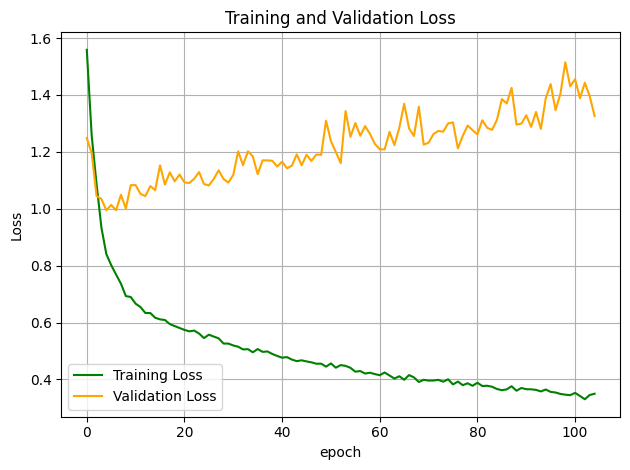

In [61]:
model7,results7=NN_hyperparameter_fit(best_hyperparameter_DCNN[0],"DCNN")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 54, 56)            224       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 27, 56)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 27, 56)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 27, 56)            9464      
                                                                 
 dense_8 (Dense)             (None, 27, 32)            1824      
                                                                 
 dense_9 (Dense)             (None, 27, 4)             132       
                                                      

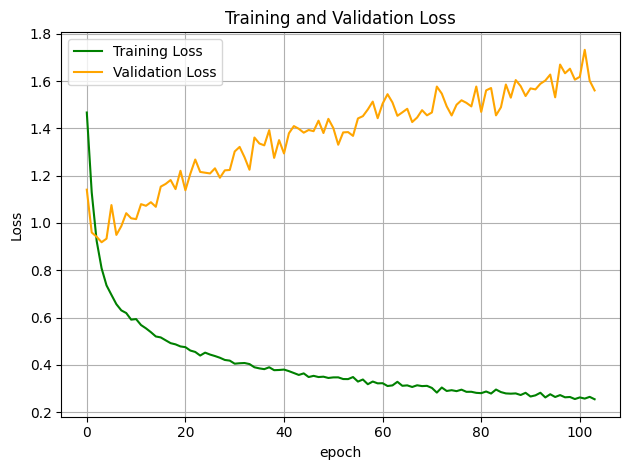

In [62]:
model8,results8=NN_hyperparameter_fit(best_hyperparameter_DCNN[1],"DCNN")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 54, 48)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 27, 48)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 27, 48)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 27, 48)            6960      
                                                                 
 dense_12 (Dense)            (None, 27, 32)            1568      
                                                                 
 dense_13 (Dense)            (None, 27, 4)             132       
                                                      

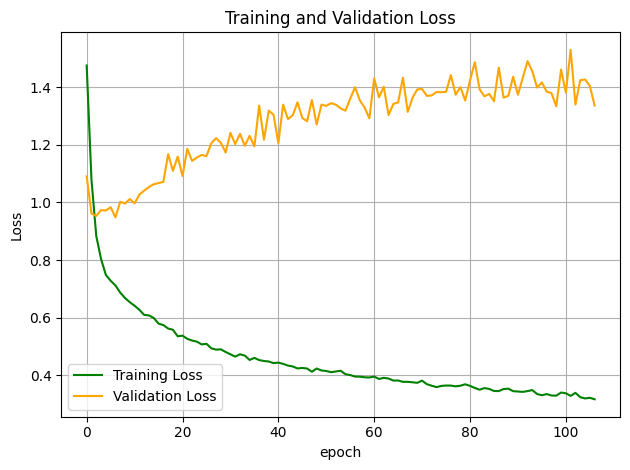

In [63]:
model9,results9=NN_hyperparameter_fit(best_hyperparameter_DCNN[2],"DCNN")

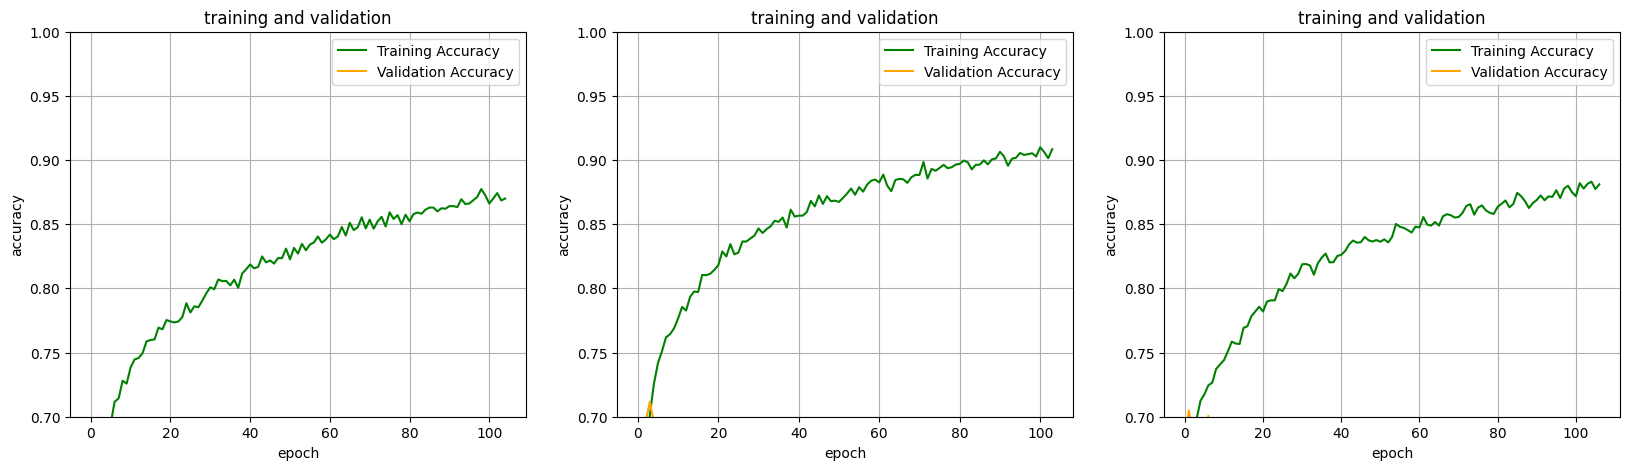

In [64]:
plot_model_performace_accuracy([results7,results8,results9])

## Train the model on all the entire dataset

In [65]:
results_total_train7 = model7.fit(dataset, labels, epochs=epochs,batch_size=batch_size)
results_total_train8 = model8.fit(dataset, labels, epochs=epochs,batch_size=batch_size)
results_total_train9 = model9.fit(dataset, labels, epochs=epochs,batch_size=batch_size)

Epoch 1/75
485/485 [==============================] - 3s 4ms/step - loss: 0.5910 - accuracy: 0.7896
Epoch 2/75
485/485 [==============================] - 2s 4ms/step - loss: 0.5571 - accuracy: 0.8011
Epoch 3/75
485/485 [==============================] - 2s 4ms/step - loss: 0.5342 - accuracy: 0.8075
Epoch 4/75
485/485 [==============================] - 2s 5ms/step - loss: 0.5276 - accuracy: 0.8042
Epoch 5/75
485/485 [==============================] - 2s 4ms/step - loss: 0.5218 - accuracy: 0.8071
Epoch 6/75
485/485 [==============================] - 2s 4ms/step - loss: 0.5177 - accuracy: 0.8075
Epoch 7/75
485/485 [==============================] - 2s 5ms/step - loss: 0.5196 - accuracy: 0.8049
Epoch 8/75
485/485 [==============================] - 2s 4ms/step - loss: 0.5058 - accuracy: 0.8120
Epoch 9/75
485/485 [==============================] - 2s 4ms/step - loss: 0.5104 - accuracy: 0.8061
Epoch 10/75
485/485 [==============================] - 2s 5ms/step - loss: 0.4986 - accuracy: 0.8138

In [66]:
models_list_DCNN = []
models_list_DCNN.append(model7)
models_list_DCNN.append(model8)
models_list_DCNN.append(model9)

In [67]:
for model in models_list_DCNN:
    predictions = model.predict(dataset_testing)
    predicted_labels = np.argmax(predictions, axis=1)
    print("Predicted labels:   ", predicted_labels)
    print("Ground-truth labels:",labels_testing)

25/25 [==============================] - 0s 2ms/step
Predicted labels:    [0 2 2 1 2 0 0 2 1 2 0 2 0 0 0 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 3 0 0 0 3 3 3 3 3 3 3 3 3 0 0 3 3 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 0 3 1 1 1 0 1 3 3 0 3 3 3 3 3 3 0 0 0 3 0 3 3 1 1 1 1 1 1 1 3 1 1
 1 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 3 3 3 3 3 1 1 1 0 0 3 3 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 2 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 3 2 3 1 0 0 0 0 0 0 0 3 0 3 2 3 0 1 0 0 0 0 0 0 2 2 2 1 2 2 2 2 1 1 1 0 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 3 0 0 0 0 0 0 0 0 0 3 3 0

## Evaluate All models and print out a table with all parameters (model , hyperparameter, accyracy, precision, recall, f1_score)

In [68]:
result_all_models_DCNN,confusion_matrix_DCNN,predicitions=evaluate_NN_models(models_list_DCNN)
## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']
data_normal_DCNN=[['DCNN model 1',' DCNN model 2', 'DCNN model 3']]
hyperparameters_values=[]
for idx, hyperparameters in enumerate(best_hyperparameter_DCNN):
  hyperparameters_values.append(hyperparameters.values)
data_normal_DCNN.append(hyperparameters_values)
data_normal_DCNN.extend(result_all_models_DCNN)
print_table(data_normal_DCNN,headers)
DCNN_classifier_accuracy=result_all_models_DCNN[0]

25/25 [==============================] - 0s 3ms/step
+--------------+-------------------------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+
| models       | hyperparameter                                                                                                                      |   accuracy |   precision |   recall |   f1_score |
+==============+=====================================================================================================================================+============+=============+==========+============+
| DCNN model 1 | {'learning_rate': 0.027024529981315975, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'lecun_normal'}   |   0.423969 |    0.329471 | 0.362644 |   0.323079 |
+--------------+---------------------------------------------------------------------------------------------------------------------------

Draw confusion matrix

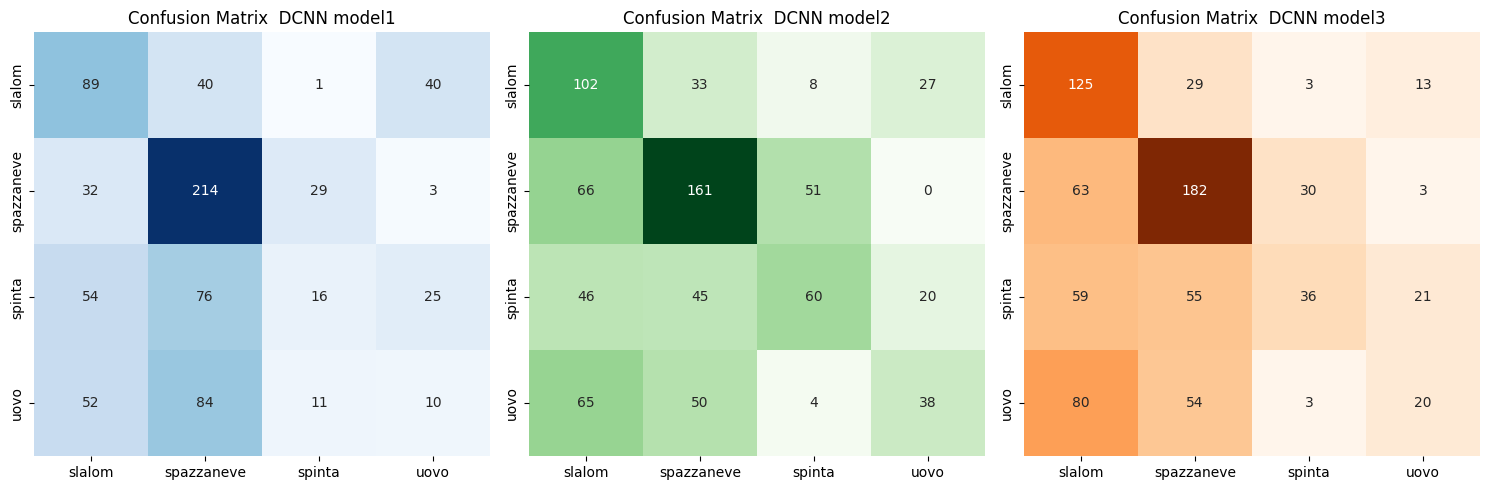

In [69]:
draw_confusion_matrix(confusion_matrix_DCNN,"DCNN model")

# **Minirocket**

In [70]:
import os
import numpy as np
import scipy.io
import random
from sktime.classification.kernel_based import RocketClassifier
import time
from tabulate import tabulate
import sklearn

In [71]:
#### function for plotting tables
def print_table(data,headers):
  table_data = list(zip(*data))
  table = tabulate(table_data, headers=headers, tablefmt='grid')
  print(table)

In [72]:
def evaluate_MiniRocket_model(model,X_test,y_test):
    accuracy , y_pred ,precision, recall ,f1_score ,support ,confusion_matrix_list = [], [], [], [], [], [], []
    print("MiniRocket Model Predicting...")
    y_pred = model.predict(X_test)
    print("MiniRocket Model Predicting Finished.")
    
    accuracy_value = sklearn.metrics.accuracy_score(y_test, y_pred)

    accuracy.append(accuracy_value)
    precision_value, recall_value, f1_score_value, support_value = sklearn.metrics.precision_recall_fscore_support(y_test , y_pred, average= 'weighted' )
    precision.append(precision_value)
    recall.append(recall_value)
    f1_score.append(f1_score_value)
    support.append(support_value)

    return [accuracy ,precision, recall ,f1_score]

In [73]:
start_time = time.time()
num_kernels = 400  # Reduced from 9996
maxDilationsPerKernel = 25  # Reduced from 64
model = RocketClassifier(num_kernels, 
                        max_dilations_per_kernel=maxDilationsPerKernel, 
                        rocket_transform='minirocket', 
                        use_multivariate='no', 
                        n_jobs=-1, 
                        random_state=42)
import numpy as np

# Assuming X_train is a numpy array
print(X_train.shape)
if X_train.shape[2] < 9:
    X_train_MR = np.pad(X_train, ((0, 0), (0, 0), (0, 9 - X_train.shape[2])))

model.fit(X_train_MR, y_train)
end_time = time.time()

print("Validation set results:")
result_all_models_FC=evaluate_MiniRocket_model(model,X_val,y_val)
headers=['accuracy','precision','recall','f1_score']
data_normal_FC=[["model"]]
data_normal_FC.extend(result_all_models_FC)
print_table(data_normal_FC,headers)

(5408, 54)


IndexError: tuple index out of range

# **Wavenet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel, RandomSearch
import os

In [ ]:
class DilatedConv1DResidual(layers.Layer):
  def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
    super(DilatedConv1DResidual, self).__init__(**kwargs)
    self.dilated_conv = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)
    self.batch_norm1 = layers.BatchNormalization()
    self.activation1 = layers.ReLU()
    self.dilated_conv_skip = layers.Conv1D(filters, 1, padding='causal', dilation_rate=dilation_rate)
    self.batch_norm2 = layers.BatchNormalization()

  def call(self, inputs, training=None):
    x = self.dilated_conv(inputs)
    x = self.batch_norm1(x, training=training)
    x = self.activation1(x)
    skip_connection = self.dilated_conv_skip(inputs)
    skip_connection = self.batch_norm2(skip_connection, training=training)
    return x + skip_connection

In [ ]:
class WavenetResidualBlock(layers.Layer):
  def __init__(self, filters, kernel_size, dilation_rates, **kwargs):
    super(WavenetResidualBlock, self).__init__(**kwargs)
    self.dilated_conv_layers = []
    for dilation_rate in dilation_rates:
      self.dilated_conv_layers.append(DilatedConv1DResidual(filters, kernel_size, dilation_rate))
    self.skip_connection = layers.Conv1D(filters, 1, padding='causal')

  def call(self, inputs, training=None):
    x = inputs
    skip = self.skip_connection(inputs)
    for dilated_conv in self.dilated_conv_layers:
      x = dilated_conv(x, training=training)
    return x + skip

In [ ]:
class WavenetHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        filters = hp.Int('filters', min_value=8, max_value=64, step=8)
        kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=2)
        numberOfBlocks = hp.Int('numberOfBlocks', min_value=1, max_value=4)
        numberOfResidualsPerBlock = hp.Int('numberOfResidualsPerBlock', min_value=2, max_value=8)
        dilation_rates = [2 ** i for i in range(numberOfResidualsPerBlock)]

        inputs = layers.Input(shape=self.input_shape)
        x = layers.Conv1D(filters, kernel_size, padding='causal')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        for _ in range(numberOfBlocks):
            x = WavenetResidualBlock(filters, kernel_size, dilation_rates)(x)

        # Replace the TimeDistributed wrapper with a GlobalAveragePooling1D layer
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compile the model
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]))
        model.compile(optimizer=optimizer, 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        return model

In [ ]:
def train_wavenet(model, X_train, y_train, X_val, y_val, epochs, batch_size):

  # Early stopping callback to monitor validation loss
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=150, verbose=1, mode='min')

  # Model checkpoint callback to save the best model based on validation loss
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      'best_wavenet_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

  callbacks = [early_stopping, model_checkpoint]

  # Train the model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

  return history


In [ ]:
# Create the WavenetHyperModel instance
classes = ("0", "1", "2", "3")
width = X_train.shape[1]
print(width)
y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
wavenet_model = WavenetHyperModel(input_shape=(width, features), num_classes=len(classes))

# Define hyperparameter search object (RandomSearch in this example)
tuner = BayesianOptimization(
    hypermodel=wavenet_model,  # Pass the WavenetHyperModel instance
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials
    executions_per_trial=1,  # Adjust if needed
    directory='./results',  # Save search results
    project_name='results_1'
)


# Search for the best hyperparameter configuration
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
             batch_size=batch_size)

# Get the best model after search
best_model = tuner.get_best_models()[0]

# Evaluate or use the best model (potentially retrain with all data)
best_model.evaluate(X_test, y_test)

Trial 10 Complete [00h 26m 00s]
val_accuracy: 0.8937197923660278

Best val_accuracy So Far: 0.9130434989929199
Total elapsed time: 01h 34m 04s
2/2 [==============================] - 12s 220ms/step - loss: 1.4488 - accuracy: 0.8095


[1.4488277435302734, 0.8095238208770752]

# **TensorFlow Lite model**


## Functions to evaluate and print analysis for  TFlite / quantized models

In [ ]:
import numpy as np

def evaluate(model_file, X, y, categoricalAccuarcy):
    if(categoricalAccuarcy):
      accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    else:
      accuracy = tf.keras.metrics.BinaryAccuracy()

    interpreter = tf.lite.Interpreter(model_path = model_file)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    y_preds = []  # To store the predicted labels
    y_real = []

    for x, y_true in zip(X,y):
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            x = x / input_scale + input_zero_point

        # Add an extra dimension to x
        x = np.expand_dims(x, axis=0)
        x = np.expand_dims(x, axis=-1).astype(input_details["dtype"])

        interpreter.set_tensor(input_details["index"], x)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_details["index"])[0]
        accuracy.update_state(y_true, y_pred)

        # Collect the predicted labels
        if(categoricalAccuarcy):
            y_preds.append(np.argmax(y_pred))
        else:
            y_preds.append(np.round(y_pred[0]))

        y_real.append(y_true)
    return accuracy.result(), y_preds, y_real

In [ ]:
def calculate_accuracy_quantization_full(y_prediction, y_real):
    if len(y_prediction) != len(y_real):
        raise ValueError("y_prediction and y_real must have the same length.")

    num_correct = sum(1 for pred, real in zip(y_prediction, y_real) if pred == real)
    total_predictions = len(y_prediction)

    accuracy = num_correct / total_predictions

    return accuracy

In [ ]:
'''def evaluate_tflite_quantized_models(models_list,base_filename_model,models_files,full=False):
  tflite_model_accuracy,tflite_model_predicitons,y_true,precisions_tf_lite_model,recalls_tf_lite_model,f1_scores_tf_lite_model,confusion_tflite_matrix_list = [], [], [] ,[],[], [], []
  for i in range(len(models_list)):
    path = base_filename_model + '/' + models_files[i].name
    print("path",path)
    accuracy, y_pred, y_real = evaluate(path, X_test, y_test, True)
    accuracy=accuracy.numpy()
    tflite_model_predicitons.append(y_pred)
    y_true.append(y_real)
    # print(f"TFLite model {i+1} accuracy = {tflite_model_accuracy[i]:.4f}")
    if full==True:
      y_pred = [np.round(value / 255) for value in y_pred]
      accuracy = calculate_accuracy_quantization_full(y_pred, y_real)
    tflite_model_accuracy.append(accuracy)
    precision_value, recall_value, f1_score_value, support_value = sklearn.metrics.precision_recall_fscore_support(y_real , y_pred, average= 'micro' )
    precisions_tf_lite_model.append(precision_value)
    recalls_tf_lite_model.append(recall_value)
    f1_scores_tf_lite_model.append(f1_score_value)
    confusion_matrix_value=confusion_matrix(y_test, y_pred)
    confusion_tflite_matrix_list.append(confusion_matrix_value)
  return [tflite_model_accuracy,precisions_tf_lite_model,recalls_tf_lite_model,f1_scores_tf_lite_model],confusion_tflite_matrix_list,tflite_model_predicitons
'''
def evaluate_tflite_quantized_models(models_list,base_filename_model,models_files,full=False):
  tflite_model_accuracy,tflite_model_predicitons,y_true,precisions_tf_lite_model,recalls_tf_lite_model,f1_scores_tf_lite_model,confusion_tflite_matrix_list = [], [], [] ,[],[], [], []
  for i in range(len(models_list)):
    path = base_filename_model + '/' + models_files[i].name
    print("path",path)
    accuracy, y_pred, y_real = evaluate(path, X_test, y_test, True)
    accuracy=accuracy.numpy()
    tflite_model_predicitons.append(y_pred)
    y_true.append(y_real)
    if full==True:
      y_pred = [np.argmax(y) for y in y_pred]  # Convert predictions to class labels
      accuracy = calculate_accuracy_quantization_full(y_pred, y_real)
    tflite_model_accuracy.append(accuracy)
    precision_value, recall_value, f1_score_value, support_value = sklearn.metrics.precision_recall_fscore_support(y_real , y_pred, average= 'micro' )
    precisions_tf_lite_model.append(precision_value)
    recalls_tf_lite_model.append(recall_value)
    f1_scores_tf_lite_model.append(f1_score_value)
    confusion_matrix_value=confusion_matrix(y_test, y_pred)
    confusion_tflite_matrix_list.append(confusion_matrix_value)
  return [tflite_model_accuracy,precisions_tf_lite_model,recalls_tf_lite_model,f1_scores_tf_lite_model],confusion_tflite_matrix_list,tflite_model_predicitons

## Converting all models to TFlite model using tensorflow lite converter

In [ ]:
models_list=[model4,model5,model6,model7,model8,model9]#model1,model2,model3

In [ ]:
tflite_models = []
for index in range(len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[index])
  tflite_models.append(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp08k5mc64\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp08k5mc64\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpdz0j5axk\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpdz0j5axk\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpx90uxpci\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpx90uxpci\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpfnfb3z39\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpfnfb3z39\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpw03v80iy\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpw03v80iy\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpylzmzyav\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpylzmzyav\assets


## It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data. We can store the models in a file in order to estimate its size:

In [ ]:
import pathlib
import os
tflite_models_dir = pathlib.Path("./")
base_filename_model_tflite = 'tflite_model'
path = tflite_models_dir/base_filename_model_tflite

if not os.path.exists(path):
  os.makedirs(path)

tflite_model_files = []
tflite_model_size = []

for i in range(1, len(models_list) +1):
  filename = f"{base_filename_model_tflite}_{i}.tflite"
  tflite_model_files.append(path/filename)
  tflite_model_files[i-1].write_bytes(tflite_models[i-1])
  tflite_model_size.append(os.path.getsize(tflite_model_files[i -1]) / float(2**10))
  print("TFlite model in KB:", tflite_model_size[i-1])

TFlite model in KB: 34.90234375
TFlite model in KB: 38.109375
TFlite model in KB: 39.74609375
TFlite model in KB: 44.81640625
TFlite model in KB: 60.0859375
TFlite model in KB: 39.50390625


## Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model

In [ ]:
import sklearn.metrics
tflite_all_results, confusion_tflite_all, tflite_predictions = evaluate_tflite_quantized_models(models_list,base_filename_model_tflite,tflite_model_files)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_tflite=[['tflite CNN model 1','tflite CNN model 2', 'tflite CNN model 3',
              'tflite DCNN model 1','tflite DCNN model 2', 'tflite DCNN model 3']]
              #'tflite MLP model 1','tflite MLP model 2', 'tflite MLP model 3',
hyperparameters_values=[]

#for i in range(len(top_three_indexes)):
  #hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")


for idx, hyperparameters in enumerate(best_hyperparameter_CNN):
  hyperparameters_values.append(hyperparameters.values)


for idx, hyperparameters in enumerate(best_hyperparameter_DCNN):
  hyperparameters_values.append(hyperparameters.values)

data_tflite.append(hyperparameters_values)
data_tflite.extend(tflite_all_results)
data_tflite.append(tflite_model_size)
print_table(data_tflite,headers)
NN_model_sizes=tflite_model_size

path tflite_model/tflite_model_1.tflite


ValueError: Cannot set tensor: Dimension mismatch. Got 4 but expected 3 for input 0.

# **Post-training quantization**

We can enable the default optimizations flag to quantize all fixed parameters (weights and biases) to 8-bit integers. Notice that scale and zero point for weights and bias can be calculated before the inference, becouse their ranges are already available. But how we can calculate scale and zero point for activations? We can use the **dynamic quantization**, in which scale and zero point for activations are calculated on-the-fly (online during inference). This means that the activations are always stored in float 32 and they are converted to integers while processing and back to floating point after the processing is done.

## **Dynamic Quantization** (not accepted in arduino)

In [ ]:
tflite_dynamic_quantized_models = []

for i in range (0 , len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_dynamic_quantized_models.append(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp96rndd1h\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp96rndd1h\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpl2av12wc\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpl2av12wc\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpa27cr2w_\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpa27cr2w_\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp1asj8x3h\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp1asj8x3h\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp2bg8n8gd\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp2bg8n8gd\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpq_69iwu6\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpq_69iwu6\assets


In [ ]:
tflite_dynamic_quantized_model_files = []
tflite_dynamic_quantized_model_size = []

base_filename_dynamic = 'tflite_dynamic_quantized_model'
path = tflite_models_dir/base_filename_dynamic

if not os.path.exists(path):
  os.makedirs(path)

for i in range (1, len(models_list) + 1):
  file_name =  f"{base_filename_dynamic}_{i}.tflite"
  tflite_dynamic_quantized_model_files.append(path/file_name)
  tflite_dynamic_quantized_model_files[i-1].write_bytes(tflite_dynamic_quantized_models[i-1])
  tflite_dynamic_quantized_model_size.append(os.path.getsize(tflite_dynamic_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite dynamic quantized model in KB:", tflite_dynamic_quantized_model_size[i-1])

TFlite dynamic quantized model in KB: 42.34375
TFlite dynamic quantized model in KB: 43.0625
TFlite dynamic quantized model in KB: 42.3984375
TFlite dynamic quantized model in KB: 56.84375
TFlite dynamic quantized model in KB: 46.25
TFlite dynamic quantized model in KB: 46.296875


### Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model_dynamic_models

In [ ]:
dynamic_quantized_all_results, confusion_dynamic_quantized_all, dynamic_quantized_predictions = evaluate_tflite_quantized_models(models_list,base_filename_dynamic,tflite_dynamic_quantized_model_files)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_dynamic_quantized=[['Dynamic quantized CNN model 1','Dynamic quantized CNN model 2', 'Dynamic quantized CNN model 3',
                         'Dynamic quantized DCNN model 1','Dynamic quantized DCNN model 2', 'Dynamic quantized DCNN model 3']]
#Dynamic quantized MLP model 1','Dynamic quantized MLP model 2', 'Dynamic quantized MLP model 3'
data_dynamic_quantized.append(hyperparameters_values)
data_dynamic_quantized.extend(dynamic_quantized_all_results)
data_dynamic_quantized.append(tflite_dynamic_quantized_model_size)
print_table(data_dynamic_quantized,headers)

path tflite_dynamic_quantized_model/tflite_dynamic_quantized_model_1.tflite
path tflite_dynamic_quantized_model/tflite_dynamic_quantized_model_2.tflite
path tflite_dynamic_quantized_model/tflite_dynamic_quantized_model_3.tflite


path tflite_dynamic_quantized_model/tflite_dynamic_quantized_model_4.tflite
path tflite_dynamic_quantized_model/tflite_dynamic_quantized_model_5.tflite
path tflite_dynamic_quantized_model/tflite_dynamic_quantized_model_6.tflite
+--------------------------------+-----------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+-----------------+
| models                         | hyperparameter                                                                                                        |   accuracy |   precision |   recall |   f1_score |   model size KB |
+================================+=======================================================================================================================+============+=============+==========+============+=================+
| Dynamic quantized CNN model 1  | {'learning_rate': 0.0001, 'optimizer': 'adam', 'filters': 56, 'dr

## **Static Quantization**
The model is now smaller with quantized weights with some decrease in the accuracy, but other variable data are still in float format. To quantize variable data (input/output and intermediates between layers), we can use **static quantization** to pre-computes scales and zero points also for all variable data in order to eliminate this overhead. However, we need some representative data in order to collect the distribution statistics for all the variable data and compute an estime of scales and zero points. The short-coming is that if the data is not representative, the scales and zero points computed might not reflect the true scenario during inference, and the inference accuracy will be harmed.

In [ ]:
def representative_data_gen():
  # Convert X_train to float32 and add an extra dimension
  X_train_2d = np.expand_dims(X_train.astype(np.float32), axis=-1)
  for input_value in tf.data.Dataset.from_tensor_slices(X_train_2d).batch(1).take(100):
    yield [input_value]

tflite_static_quantized_models = []

for i in range (0 , len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  tflite_static_quantized_models.append(converter.convert())


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp7hynw5ip\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp7hynw5ip\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpogr4q4r5\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpogr4q4r5\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpqqx_e1kq\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpqqx_e1kq\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpatou9o5w\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpatou9o5w\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp_mp4_9l7\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp_mp4_9l7\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpmujefp7m\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpmujefp7m\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
tflite_static_quantized_model_files = []
tflite_static_quantized_model_size = []

base_filename_static = 'tflite_static_quantized_model'
path = tflite_models_dir/base_filename_static

if not os.path.exists(path):
  os.makedirs(path)

for i in range (1, len(models_list) + 1):
  file_name =  f"{base_filename_static}_{i}.tflite"
  tflite_static_quantized_model_files.append(path/file_name)
  tflite_static_quantized_model_files[i - 1].write_bytes(tflite_static_quantized_models[i - 1])
  tflite_static_quantized_model_size.append(os.path.getsize(tflite_static_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite static quantized model in KB:", tflite_static_quantized_model_size[i-1])

TFlite static quantized model in KB: 43.484375
TFlite static quantized model in KB: 41.53125
TFlite static quantized model in KB: 43.5390625
TFlite static quantized model in KB: 58.9765625
TFlite static quantized model in KB: 45.125
TFlite static quantized model in KB: 45.1640625


### Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model_static_models

In [ ]:
static_quantized_all_results, confusion_static_quantized_all, static_quantized_predictions = evaluate_tflite_quantized_models(models_list,base_filename_static,tflite_static_quantized_model_files)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_static_quantized=[['Static quantized CNN model 1','Static quantized CNN model 2', 'Static quantized CNN model 3',
                        'Static quantized DCNN model 1','Static quantized DCNN model 2', 'Static quantized DCNN model 3']]
#'Static quantized MLP model 1','Static quantized MLP model 2', 'Static quantized MLP model 3',
data_static_quantized.append(hyperparameters_values)
data_static_quantized.extend(static_quantized_all_results)
data_static_quantized.append(tflite_static_quantized_model_size)
print_table(data_static_quantized,headers)

path tflite_static_quantized_model/tflite_static_quantized_model_1.tflite


path tflite_static_quantized_model/tflite_static_quantized_model_2.tflite
path tflite_static_quantized_model/tflite_static_quantized_model_3.tflite
path tflite_static_quantized_model/tflite_static_quantized_model_4.tflite
path tflite_static_quantized_model/tflite_static_quantized_model_5.tflite
path tflite_static_quantized_model/tflite_static_quantized_model_6.tflite
+------------------------------+-----------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+-----------------+
| models                       | hyperparameter                                                                                                        |   accuracy |   precision |   recall |   f1_score |   model size KB |
+==============================+=======================================================================================================================+============+=============+=======

## **Full Static Quantization** (Not necessary)
Now all weights and variable data are quantized. However, to maintain compatibility with applications that traditionally use float model, the TensorFlow Lite Converter leaves the model input and output tensors in float. This is good for compatibility, but it won't be compatible with devices that perform only integer-based operations. To ensure end-to-end integer-only model, we need to specify some parameters to the converter.

In [ ]:
tflite_full_static_quantized_models = []

for i in range(0, len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_full_static_quantized_models.append(converter.convert())

INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp3j7n6i4j\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp3j7n6i4j\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpl6l4w9e3\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpl6l4w9e3\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpjn9luzvs\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpjn9luzvs\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpm71vvvnh\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpm71vvvnh\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp_bsoeg81\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmp_bsoeg81\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpssz7nuw9\assets


INFO:tensorflow:Assets written to: C:\Users\JAVIE_~1\AppData\Local\Temp\tmpssz7nuw9\assets
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### The internal quantization remains the same as above, but we can see the input and output tensors are now integer format:

In [ ]:

interpreter = tf.lite.Interpreter(model_content = tflite_full_static_quantized_models[0])
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [ ]:

tflite_full_static_quantized_model_files = []
tflite_full_static_quantized_model_size = []

base_filename_full_static = 'tflite_full_static_quantized_model'
path = tflite_models_dir/base_filename_full_static

if not os.path.exists(path):
  os.makedirs(path)

for i in range(1, len(models_list) + 1) :
  file_name =  f"{base_filename_full_static}_{i}.tflite"
  tflite_full_static_quantized_model_files.append(path/file_name)
  tflite_full_static_quantized_model_files[i - 1].write_bytes(tflite_full_static_quantized_models[i - 1])
  tflite_full_static_quantized_model_size.append(os.path.getsize(tflite_full_static_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite full static quantized model in KB:", tflite_full_static_quantized_model_size[i-1])

TFlite full static quantized model in KB: 43.5
TFlite full static quantized model in KB: 41.5625
TFlite full static quantized model in KB: 43.5703125
TFlite full static quantized model in KB: 58.9921875
TFlite full static quantized model in KB: 45.15625
TFlite full static quantized model in KB: 45.1953125


### Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model_full_static_models

In [ ]:

full_static_quantized_all_results, confusion_full_static_quantized_all, full_static_quantized_predictions = evaluate_tflite_quantized_models(models_list,base_filename_full_static,tflite_full_static_quantized_model_files,full=True)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_full_static_quantized=[['Full static quantized CNN model 1','full static quantized CNN model 2', 'full static quantized CNN model 3',
                             'Full static quantized DCNN model 1','full static quantized DCNN model 2', 'full static quantized DCNN model 3']]
                             #'Full static quantized MLP model 1','full static quantized MLP model 2', 'full static quantized MLP model 3'
data_full_static_quantized.append(hyperparameters_values)
data_full_static_quantized.extend(full_static_quantized_all_results)
data_full_static_quantized.append(tflite_full_static_quantized_model_size)
print_table(data_full_static_quantized,headers)

path tflite_full_static_quantized_model/tflite_full_static_quantized_model_1.tflite
path tflite_full_static_quantized_model/tflite_full_static_quantized_model_2.tflite
path tflite_full_static_quantized_model/tflite_full_static_quantized_model_3.tflite


path tflite_full_static_quantized_model/tflite_full_static_quantized_model_4.tflite
path tflite_full_static_quantized_model/tflite_full_static_quantized_model_5.tflite
path tflite_full_static_quantized_model/tflite_full_static_quantized_model_6.tflite
+------------------------------------+-----------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+-----------------+
| models                             | hyperparameter                                                                                                        |   accuracy |   precision |   recall |   f1_score |   model size KB |
+====================================+=======================================================================================================================+============+=============+==========+============+=================+
| Full static quantized CNN model 1  | {'learning_rate': 0.0001,

# **Best models**

In [ ]:
linear_index=linear_classifier_accuracy.index(max(linear_classifier_accuracy))
#MLP_index=MLP_classifier_accuracy.index(max(MLP_classifier_accuracy))
CNN_index=CNN_classifier_accuracy.index(max(CNN_classifier_accuracy))
DCNN_index=DCNN_classifier_accuracy.index(max(DCNN_classifier_accuracy))
print(linear_index,CNN_index,DCNN_index)
#MLP_index

tflite_modelfiles_best=[tflite_model_files[CNN_index + 0],tflite_model_files[DCNN_index + 3]]
#tflite_model_files[MLP_index],
dynamic_modelfiles_best=[tflite_dynamic_quantized_model_files[CNN_index + 0],tflite_dynamic_quantized_model_files[DCNN_index + 3]]
#tflite_dynamic_quantized_model_files[MLP_index],
static_modelfiles_best=[tflite_static_quantized_model_files[CNN_index + 0],tflite_static_quantized_model_files[DCNN_index + 3]]
#tflite_static_quantized_model_files[MLP_index],

4 2 2


# **Quantization Aware Training**
Quantization introduces information loss and therefore the inference accuracy from the quantized integer models are inevitably lower than that from the floating point models. Such information loss is due to that the floating points after quantization and de-quantization is not exactly recoverable. The idea of quantization aware training is to ask the neural network to take the effect of such information loss into account during training. We can use the TensorFlow Model Optimization toolkit and passing in input the Keras model. What that API is doing is extending that network with the ability to mimic the quantized behavior that would be happening during the inference time, during the training time.# Aware Quantization

## Functions for building aware CNN and DCNN models

In [ ]:
num_classes=4

In [ ]:
import tensorflow_model_optimization as tfmot

class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, tfmot.quantization.keras.LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    def get_activations_and_quantizers(self, layer):
        return [(layer.activation, tfmot.quantization.keras.MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
        layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
        layer.activation = quantize_activations[0]

    def get_output_quantizers(self, layer):
        return []

    def get_config(self):
        return {}

In [ ]:
import tensorflow_model_optimization as tfmot

def build_model_aware_CNN(hp, kernel_size=3):

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    # Tune the number of filters in the Conv1D layer
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=8)
    # Tune the dropout values
    dropout_rate = hp.Choice('dropout', values=[0.7])
    # Tune weights initialization
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))  # Adjusted for 1D input

    # Define the Conv1D layer and annotate it for quantization
    conv1d_layer = tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernel_size, activation='relu', kernel_initializer=kernel_initializer)
    quantized_conv1d_layer = tfmot.quantization.keras.quantize_annotate_layer(conv1d_layer, DefaultDenseQuantizeConfig())

    # Add the quantized layer to the model
    model.add(quantized_conv1d_layer)
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.01)))

    model.add(tf.keras.layers.Dropout(rate = dropout_rate))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Activation('softmax'))

    # Apply quantization to the model
    quantize_model = tfmot.quantization.keras.quantize_model

    # q_aware stands for for quantization aware.
    q_aware_model = quantize_model(model)

    # Compile the model with the hyperparameters
    q_aware_model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    return q_aware_model


In [ ]:
'''
def build_model_aware_fc(quantizator,number_of_hidden_layers=1,number_of_units=128):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height)))
    model.add(tf.keras.layers.Flatten())
    for i in range(1,number_of_hidden_layers+1):
      model.add(tf.keras.layers.Dense( number_of_units/i, activation='relu'))
      model.add(tf.keras.layers.Dropout(rate = 0.3))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    quantization_aware_model = quantizator(model)
     # Compile the model with the hyperparameters
    quantization_aware_model.compile(optimizer="adam",
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)
    quantization_aware_model.summary()
    return quantization_aware_model
    '''

'\ndef build_model_aware_fc(quantizator,number_of_hidden_layers=1,number_of_units=128):\n\n    model = tf.keras.Sequential()\n    model.add(tf.keras.layers.InputLayer(input_shape=(width, height)))\n    model.add(tf.keras.layers.Flatten())\n    for i in range(1,number_of_hidden_layers+1):\n      model.add(tf.keras.layers.Dense( number_of_units/i, activation=\'relu\'))\n      model.add(tf.keras.layers.Dropout(rate = 0.3))\n    model.add(tf.keras.layers.Dense(1,activation=\'sigmoid\'))\n\n    quantization_aware_model = quantizator(model)\n     # Compile the model with the hyperparameters\n    quantization_aware_model.compile(optimizer="adam",\n                  loss=\'binary_crossentropy\',\n                  metrics=[\'accuracy\'],)\n    quantization_aware_model.summary()\n    return quantization_aware_model\n    '

In [ ]:
def build_model_aware_DCNN(quantizator,number_of_convolutional=2,kernal_size=[5,3]):

    quantizator_learning_rate = quantizator.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
    quantizator_optimizer = quantizator.Choice('optimizer', values=['adam'])
    quantizator_filters = quantizator.Int('filters', min_value=16, max_value=64, step=8)
    dropout_rate = quantizator.Choice('dropout', values=[0.7])
    kernel_initializer = quantizator.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))
    for i in range(number_of_convolutional - 1):
      model.add(tf.keras.layers.Conv1D(filters = quantizator_filters , kernel_size=kernal_size[i], activation='relu',padding='same', kernel_initializer=kernel_initializer))
      model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
      model.add(tf.keras.layers.Dropout(rate = dropout_rate))

    model.add(tf.keras.layers.Conv1D(filters = quantizator_filters , kernel_size=kernal_size[len(kernal_size)-1], activation='relu',padding='same', kernel_initializer=kernel_initializer))

    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer)) # num_classes is the number of classes in your problem
    model.add(tf.keras.layers.Activation('softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    quantization_aware_model = quantizator(model)
    quantization_aware_model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    quantization_aware_model.summary()
    return quantization_aware_model

In [ ]:
## since our study on three different comination of the hyperparameters we will create three aware training quantizations models in order to compare the results
from kerastuner import HyperParameters

import tensorflow_model_optimization as tfmot
quantizator = tfmot.quantization.keras.quantize_model
#quantization_aware_model1=build_model_aware_fc(quantizator)
hp = HyperParameters()
quantization_aware_model2 = build_model_aware_CNN(hp)
quantization_aware_model3=build_model_aware_DCNN(quantizator)

ValueError: Unable to clone model. This generally happens if you used custom Keras layers or objects in your model. Please specify them via `quantize_scope` for your calls to `quantize_model` and `quantize_apply`. [Unknown None: DefaultDenseQuantizeConfig. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.].

## When we train the networks, it is implicitly learning to be resilient to the quantization error.

In [ ]:
#aware_results1 = quantization_aware_model1.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_val, y_val))
aware_results2 = quantization_aware_model2.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_val, y_val))
aware_results3 = quantization_aware_model3.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
plot_model_performace_accuracy([aware_results2,aware_results3])
#aware_results1,

In [ ]:
aware_model_list=[quantization_aware_model2,quantization_aware_model3]
#quantization_aware_model1

In [ ]:
tflite_aware_quantized_models = []
for i in range(0, len(aware_model_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(aware_model_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_aware_quantized_models.append(converter.convert())

interpreter = tf.lite.Interpreter(model_content = tflite_aware_quantized_models[0])
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

tflite_aware_quantized_model_files = []
tflite_aware_quantized_model_size = []

base_filename_aware = 'tflite_aware_quantized_model'
path = tflite_models_dir/base_filename_aware

if not os.path.exists(path):
  os.makedirs(path)

for i in range(1, len(aware_model_list) + 1) :
  file_name =  f"{base_filename_aware}_{i}.tflite"
  tflite_aware_quantized_model_files.append(path/file_name)
  tflite_aware_quantized_model_files[i - 1].write_bytes(tflite_aware_quantized_models[i - 1])
  tflite_aware_quantized_model_size.append(os.path.getsize(tflite_aware_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite aware quantized model in KB:", tflite_aware_quantized_model_size[i-1])


## Calculate Accuracy, Precision, Recall, F1 Tf_lite_aware_quantized_model

In [ ]:
aware_quantized_all_results, confusion_aware_quantized_all, aware_quantized_predictions = evaluate_tflite_quantized_models(aware_model_list,base_filename_aware,tflite_aware_quantized_model_files,full=True)
## create a table with all tf lite models results
headers=['models''accuracy','precision','recall','f1_score','model size KB']
data_aware_quantized=[['Aware quantized MLP model ','Aware quantized model CNN ', 'Aware quantized DCNN model ']]
data_aware_quantized.extend(aware_quantized_all_results)
data_aware_quantized.append(tflite_aware_quantized_model_size)
print_table(data_aware_quantized,headers)

# **Benchmark Models with STM tools**


In [ ]:
# download from github requirement.txt
import requests

github_file_url = 'https://github.com/STMicroelectronics/stm32ai-modelzoo/blob/main/requirements.txt'
local_file_path = 'requirements.txt'

response = requests.get(github_file_url)

if response.status_code == 200:
    json_data = response.json()  # Converti la risposta in JSON
    file_content = json_data['payload']['blob']['rawLines']  # Estrai il contenuto del file

    with open(local_file_path, 'w') as file:
        for line in file_content:
            file.write(line + '\n')

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
import os
import tensorflow as tf

classes = 4

# Define filter sizes and number of Conv1D layers to try
filters_list = [32]
conv_layers_list = [3]

for num_filters in filters_list:
    for num_conv_layers in conv_layers_list:
        print(f"Building model with {num_conv_layers} Conv1D layers and {num_filters} filters in each")

        # Define the model
        model = Sequential()
        model.add(Conv1D(num_filters, kernel_size=3, activation='relu', input_shape=(lenTimeserie, 6)))
        model.add(MaxPooling1D(pool_size=2))

        # Add additional Conv1D layers based on the current configuration
        for _ in range(1, num_conv_layers):
            model.add(Conv1D(num_filters, kernel_size=3, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))

        model.summary()

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Define callbacks (assuming x_train, y_train, x_val, y_val are already defined)
        base_filename = f'CNN_{num_conv_layers}_conv_{num_filters}_filters_1.h5'
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min'),
            tf.keras.callbacks.ModelCheckpoint(base_filename, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        ]

        # Train the model
        history = model.fit(X_train, y_train, epochs=1500, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

        models_name=["CNN_3_conv_32_filters_1BEST.h5"]
#dataset_testing, labels_testing
for model_name in models_name:
    model = tf.keras.models.load_model(model_name)
    predictions = model.predict(dataset_testing)
    predicted_labels = np.argmax(predictions, axis=1)
    print("Predicted labels:   ", predicted_labels)
    print("Ground-truth labels:",labels_testing)

    import utils
for model_name in models_name:
    model = tf.keras.models.load_model("./"+model_name)
    result_all_models_FC,confusion_matrix_FC,predicitions_FC=utils.evaluate_NN_models([model],X_test,y_test)
    headers=['models','accuracy','precision','recall','f1_score']
    data_normal_FC=[["CNN"]]
    data_normal_FC.extend(result_all_models_FC)
    utils.print_table(data_normal_FC,headers) 
    utils.draw_confusion_matrix(confusion_matrix_FC,model_name)